# Analysis Jupyter Notebook
### Controlla il path della cartella

## Data Handling

### Command for clustsize

clust_cmd = 'gmx_mpi clustsize -f prod_2000-1mM.xtc -dt 100000 -s prod_2000-1mM.tpr -mol -hct -nice 0 -cut 0.4'
!{clust_cmd}

import gromacs
from gromacs.fileformats import * #NDX, uniqueNDX
from gromacs import cbook


# Sistemare che forse diventa piu' breve



#print(gromacs.release())

### Creation of the system.ndx
gromacs.make_ndx(f='prod_2000-1mM.tpr', o='system.ndx', input=('q'), stdout=False)

### Merge the system.ndx and maxclust.ndx
!{'cat system.ndx maxclust.ndx > full.ndx'}

### Import the index as uniqueNDX to perform some operations
full_ndx = uniqueNDX('full.ndx')

### Creation of a dictionary which includes the index names and the atomnumber
full_dict = full_ndx.sizes

### Extraction of all the clusters, remove the max_clust (duplicated) and make a list of them
fibril_dict = {key:val for key, val in full_dict.items() if val != 85}
fibril_list = list(fibril_dict.keys())
fibril_list.remove('max_clust')

### Extraction of all the single molecules not part of a fibril and make a list of that
not_fibril_dict = {key:val for key, val in full_dict.items() if val == 85}
not_fibril_list = list(not_fibril_dict.keys())

### Print the lists to paste below
print(fibril_list)
print(len(fibril_list))

print(not_fibril_list)
print(len(not_fibril_list))


In [ ]:
### Creation of one indexe which includes all the atoms in a cluster
full_ndx['fibril'] = full_ndx.join('clust 1113', 'clust 791', 'clust 1199', 'clust 1665', 'clust 849', 'clust 846', 'clust 875', 'clust 1035', 'clust 1224', 'clust 1390', 'clust 1146', 'clust 321', 'clust 1194')

### Creation of a second index which includes all the atoms not in a fibril
full_ndx['not_fibril'] = full_ndx.join('clust 263', 'clust 302', 'clust 318', 'clust 319', 'clust 396', 'clust 657', 'clust 709', 'clust 741', 'clust 766', 'clust 823', 'clust 895', 'clust 997', 'clust 1133', 'clust 1190', 'clust 1225', 'clust 1235', 'clust 1245', 'clust 1266', 'clust 1297', 'clust 1299', 'clust 1308', 'clust 1456', 'clust 1492', 'clust 1600', 'clust 1657', 'clust 1669', 'clust 1768', 'clust 1887', 'clust 1915')

### Write the new index which will be used to create a different set of pdbs and used to create a pdb with the correct atom number (pdb numerical limit to 6 digits)
full_ndx.write('pdb.ndx')

#fib = full_ndx['fibril']
#not_fib = full_ndx['not_fibril']
#print(len(full_ndx['fibril']))
#print(len(full_ndx['not_fibril']))     # Questi sono ok, 170000 totali

In [21]:
### Editconf included in GromacsWrapper apparently does not include the ndx argument.
### Gmxapi does not even have editconf, apparently
import gmxapi as gmx

prova_editconf = gmx.commandline_operation('gmx', arguments=['editconf', '-label', 'A'], input_files={'-f': 'prod_2000-1mM.tpr', '-n': 'pdb.ndx'}, output_files={'-o': 'clust.pdb'})


clustpdb = prova_editconf.output.file['-o'].result()
if prova_editconf.output.returncode.result() !=0:
    print(prova_editconf.output.erroroutput.result())



#!{'./script-pdb.sh'} Questo funziona, bisogna sistemare un po'  una sorta di append.

:-) GROMACS - gmx editconf, 2020.3-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
        Mark Abr

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

%pwd
#%cd /media/data/emanuele/TTR/smog-to-gromos/old/fix-concentration_gradient/make_fibrillone-2000-296K-1mM-bis/analysis

### Data import

matrix = pd.read_csv('histo-time.dat', sep = '\\s+', header = None)

# Changing the index so now it is in picoseconds
#matrix[0] = matrix[0].apply(lambda x:x*10)
#matrix = matrix.set_index([0])

### Data handling
#### Defining the Maxclust and the number of frames
clustsize = list(range(0, len(matrix.columns), 1))
frames = list(range(0, len(matrix.index), 1))
fibril = list(range(2, len(matrix.columns)))
#not_fibril = list(range(3, 10, 1))


#### Multiply the columns for its clustsize
size = pd.Series(clustsize)
matrix = matrix.mul(size, axis = 1)

#### Replace 0 with n.an
matrix[matrix == 0] = np.nan

#### I don't care about monomers
matrix = matrix.drop([0, 1], axis = 1)

### Make the histogram to compare with lab results
# Set the not-fibril to 0 and have a sort of lag time 
histo_zero = matrix.copy()
histo_zero[[2, 3, 4, 5, 6, 7, 8, 9, 10]] = 0
histo_zero = histo_zero[fibril].sum(axis=1)

# This one is the complete one
histogram = matrix[fibril].sum(axis=1)

# Matrix transpose
matrix = matrix.T




#print(matrix)
#print(maxclust) # seems ok
#print(frames) # seems ok

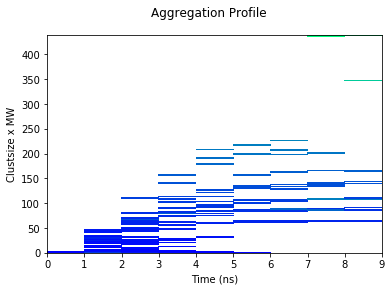

In [5]:
#prova = ListedColormap(['darkorange', 'gold', 'lawngreen', 'lightseagreen'])
plt.pcolormesh(matrix, cmap = 'winter', rasterized = True)
plt.ylabel('Clustsize x MW')
plt.xlabel('Time (ns)')
#splt.xlim(0, 1200)
plt.suptitle('Aggregation Profile')
plt.show()


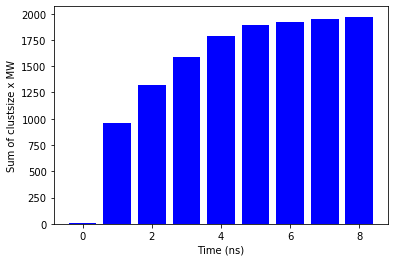

In [6]:
plt.bar(frames, histogram, color = 'blue')
plt.ylabel('Sum of clustsize x MW')
plt.xlabel('Time (ns)')
#plt.xlim(0, 1200)
plt.show()

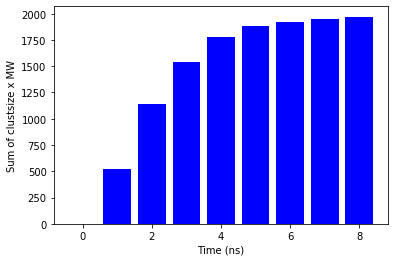

In [7]:
plt.bar(frames, histo_zero, color = 'blue')
plt.ylabel('Sum of clustsize x MW')
plt.xlabel('Time (ns)')
#plt.xlim(0, 1200)
plt.show()

In [8]:
#import gmxapi as gmx

#clust = gmx.commandline_operation('gmx_mpi',
 #                                   arguments=['clustsize', '-mol', '-nice', '0', '-cut', '0.4', '-dt', '100000'],
  #                                  input_files={'-f': 'prod_2000-1mM.xtc', '-s': 'prod_2000-1mM.tpr'})